In [1]:
from sklearn.ensemble import RandomForestClassifier

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
import xgboost as xgb
import shap

In [2]:
df=pd.read_csv('trayecto_dummies.csv')

In [3]:
df

,festivo,prev_festivo,post_festivo,mult_diag,urbano,Rural,comuna_mixta,grave,tiempo_espera,rslc_porcentaje_incapacidad,...,forma_oit_6,forma_oit_7,forma_oit_8,forma_oit_9,agente_oit_1,agente_oit_2,agente_oit_3,agente_oit_4,agente_oit_5,agente_oit_6
0,0,0,0,1,1,0,0,0,1.100000,0.0,...,0,0,0,1,1,0,0,0,0,0
1,0,0,0,1,0,0,1,0,2.850000,0.0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,1,0,0,0,2.333333,0.0,...,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0.616667,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,1,0,0,1,0.000000,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59951,0,0,0,1,0,0,1,0,6.500000,0.0,...,0,0,0,1,0,1,0,0,0,0
59952,0,0,0,0,1,0,0,0,4.266667,0.0,...,0,0,0,0,0,0,0,0,1,0
59953,0,0,0,1,1,0,0,1,8.000000,0.0,...,0,0,0,0,0,1,0,0,0,0
59954,0,0,0,0,1,0,0,0,4.233333,0.0,...,0,0,0,0,0,1,0,0,0,0


In [4]:

scaler = StandardScaler()

df['tiempo_espera'] = scaler.fit_transform(df[['tiempo_espera']])

In [5]:
X = df.drop('reposo', axis=1)
y= df['reposo']

In [6]:
y.value_counts()

reposo
0    54486
1     5470
Name: count, dtype: int64

In [7]:
# define pipeline
over = SMOTE(sampling_strategy=0.4) #aumenta la clase minoritaría al 40% de la mayoritaria
under = RandomUnderSampler(sampling_strategy=0.5) #reduce la clase mayoritaria para que represente un 50% más que la minoritaria
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_sm, y_sm = pipeline.fit_resample(X, y)

y_sm.value_counts()

reposo
0    43588
1    21794
Name: count, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm)

In [9]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [10]:
y_pred = rf.predict(X_train)

print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30511
           1       1.00      1.00      1.00     15256

    accuracy                           1.00     45767
   macro avg       1.00      1.00      1.00     45767
weighted avg       1.00      1.00      1.00     45767

[[30511     0]
 [    0 15256]]


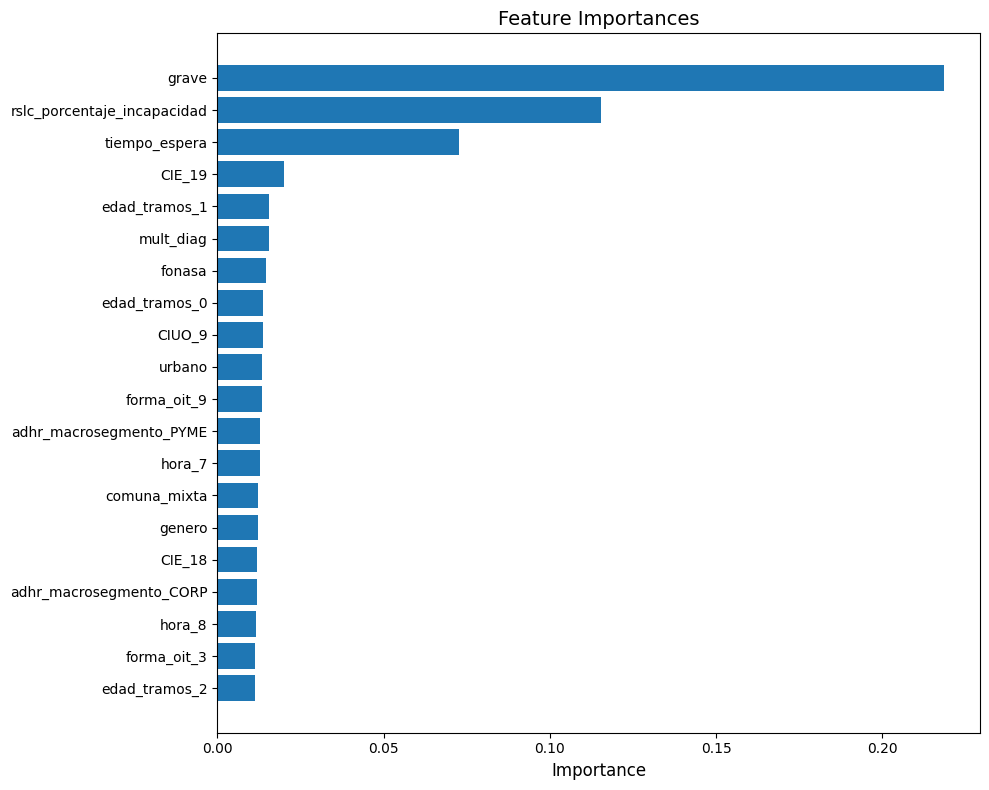

In [11]:
#muestra la importancia de cada variable

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

#grafica de las 20 variables más importantes

plt.figure(figsize=(10, 8))
plt.title("Feature Importances", fontsize=14)
plt.barh(range(20), importances[indices[:20]], align="center")
plt.yticks(range(20), X.columns[indices[:20]])
plt.gca().invert_yaxis()  # Invertir el orden de las características
plt.xlabel("Importance", fontsize=12)
plt.tight_layout()
plt.show()


In [12]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     13077
           1       0.89      0.88      0.88      6538

    accuracy                           0.92     19615
   macro avg       0.91      0.91      0.91     19615
weighted avg       0.92      0.92      0.92     19615

[[12351   726]
 [  817  5721]]


In [13]:
#kfold cross validation

kfold = KFold(n_splits=10,shuffle=True, random_state=20)
results = cross_val_score(rf, X_test, y_test, cv=kfold, scoring='accuracy')

print(results)

print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

    

[0.89143731 0.90672783 0.89755352 0.89296636 0.88430173 0.89954105
 0.89342172 0.89189189 0.89852116 0.89495156]
Accuracy: 89.51% (0.57%)
